In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [108]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# Use the Inspector to explore the database and print the table names
inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [26]:
# Use Inspector to print the column names and types
print('measurement table')
print('*'*50)
columns=inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])
    
print('')
print('station table')
print('*'*50)
columns=inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

measurement table
**************************************************
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station table
**************************************************
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [27]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [28]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [87]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2015-01-02', '2016-01-02'))

[(56.0, 73.86309278350515, 86.0)]


## Trip Date: Aug-01 to Aug 07

In [127]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a previous year in the data set

results=[]
for i in range(2010, 2017):
    result=calc_temps(f'{i}-08-01', f'{i}-08-07')
    results.append(result)

results

[[(69.0, 73.55, 80.0)],
 [(67.0, 75.24528301886792, 79.0)],
 [(67.0, 74.97826086956522, 82.0)],
 [(69.0, 76.08163265306122, 81.0)],
 [(71.0, 77.45652173913044, 83.0)],
 [(69.0, 78.27272727272727, 85.0)],
 [(72.0, 77.79545454545455, 83.0)]]

In [128]:
#list of min, avg, and max temp
tmin=[r[0][0] for r in results]
tmin=np.array(tmin)
tavg=[r[0][1] for r in results]
tmax=[r[0][2] for r in results]
tmax=np.array(tmax)

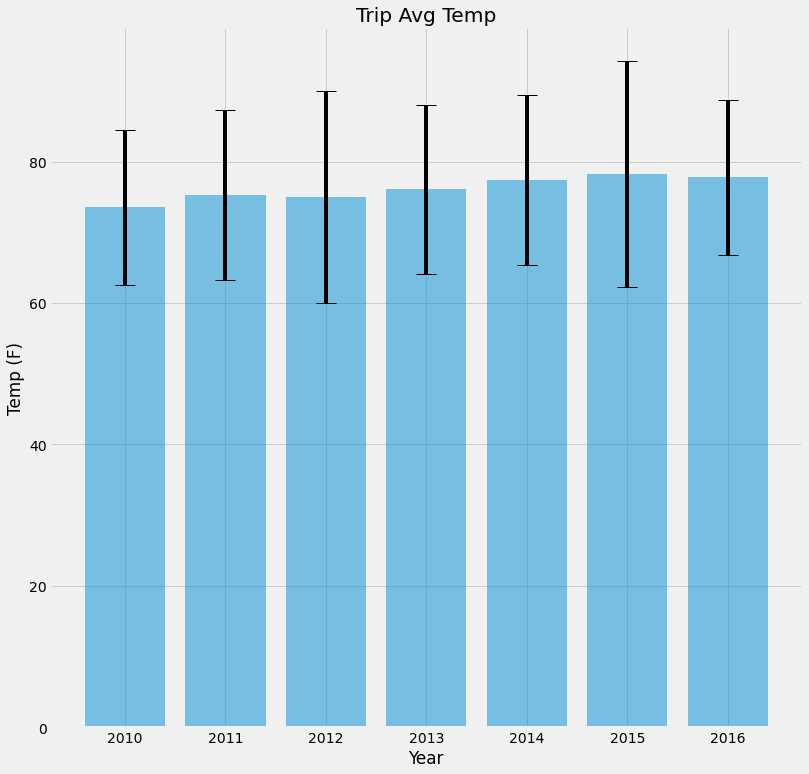

In [129]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr=tmax-tmin
year=list(range(2010,2017))
fig, ax=plt.subplots(figsize=(12,12))
ax.bar(year, tavg, yerr=yerr, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set(xlabel='Year', ylabel='Temp (F)', title='Trip Avg Temp')
plt.show()

### Daily Rainfall Average

In [130]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station,func.avg(Measurement.prcp))\
                    .group_by(Measurement.station)\
                    .order_by(func.avg(Measurement.prcp).desc()).all()

[('USC00516128', 0.4299879227053122),
 ('USC00519281', 0.2123520923520915),
 ('USC00518838', 0.20722222222222236),
 ('USC00513117', 0.14192136498516264),
 ('USC00514830', 0.12105833763551899),
 ('USC00519523', 0.11496111975116619),
 ('USC00517948', 0.06360175695461204),
 ('USC00519397', 0.0490204841713224),
 ('USC00511918', 0.04797101449275366)]

In [135]:
stmt=session.query(Measurement.station,func.avg(Measurement.prcp))\
                    .group_by(Measurement.station)\
                    .order_by(func.avg(Measurement.prcp).desc()).statement
df=pd.read_sql_query(stmt, session.bind)
df.rename(columns={'avg_1':'avg_prcp'}, inplace=True)
df.set_index('station', inplace=True)
df

,avg_prcp
station,
USC00516128,0.429988
USC00519281,0.212352
USC00518838,0.207222
USC00513117,0.141921
USC00514830,0.121058
USC00519523,0.114961
USC00517948,0.063602
USC00519397,0.049020
USC00511918,0.047971


### Daily Temperature Normals

In [31]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range=list(range(start_date, end_date))
date_range
# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


TypeError: 'str' object cannot be interpreted as an integer

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session

In [ ]:
# Close Session
session.close()